# Construction of a prediction model for Covid19
## Part 2 (for part one look at the DataExploration notebook)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from WebApp.CovidClinicalData import DataImputer

from scipy.stats import ttest_ind
from scipy.stats import chisquare
from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


We read the data file created in the Part 1 notebook

In [4]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


We are going to split the data into a training set on which we will do the parameter tuning and a test set on which we will evaluate the models' performance

In [5]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]
X, test_x, y, test_y = train_test_split(X, y, test_size=.1)

## Splitting the data

Given that the data appears in the dictionary as taken by blocks (and seen how that matches the proportion of null values for every group) I have decided to split the data into the 4 types:<br>
- <u>Epidemiological factors:</u> 'age', 'high_risk_exposure_occupation' and 'high_risk_interactions'. These will be included in all datasets since I believe it might affect the results greatly and could be easily ignored for experimentation purposes. 
- <u>Comorbidities:</u> All columns from 'diabetes' to 'smoker'. Since this is the most complete dataset (almost all instances in the original dataset are not null) we will start with this.
- <u>Vitals:</u> All of the continues values ('temperature', 'pulse', etc.) I try to use simple linear regression and compare it against both trees and xgboost algorithms.
- <u>Clinician Assessed symptoms:</u> 'ctab', 'labored_respiration', 'rhonchi' and 'wheezes'. I will use naive bayes, trees and/or xgboost.
- <u>Patient reported symptoms:</u> All remaining columns. Again, naive bayes, trees and/or xgboost.

After I have each dataset, I will impute the null corresponding to the most frequent in each case and train several models for each one of them

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [27]:
def reduce_training_set(data_x, data_y, ratio=1):
    '''
    Undersamples the 'Negative' classes so we end up with nPositives * ratio 'Negative' examples
    '''
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum() * ratio)
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    '''
        Gets evaluation metrics for a set of predictions
        values: a tuple in the form of '(actual, predictions)'
    '''
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return recall, f1 


In [7]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight=None)
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [32]:
def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, sample_weights=None):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = data_y[data_y == "Negative"].shape[0]
    negs_to_sample = min(positive_index.shape[0] * ratio_negatives_to_positives, size_of_negatives) if ratio_negatives_to_positives >=1 else size_of_negatives
    
    fold_size = positive_index.shape[0] // folds
    fold_size_neg = fold_size * ratio_negatives_to_positives if negs_to_sample < size_of_negatives else size_of_negatives // folds
    
    results = np.zeros((folds,2,2)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = DataImputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(negs_to_sample - fold_size_neg), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        
        rest_of_x = data_x.loc[~data_x.index.isin(train_x.index)] ## Al data not used by training
        valid_x = pd.concat([rest_of_x[data_y == "Negative"].sample(fold_size_neg), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        train_x = imputer.fit_transform(train_x, train_y)
        valid_x = imputer.transform(valid_x)
        
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += (f1_score(*train_v, pos_label="Positive"), roc_auc_score(train_y, t_pred_prob)) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += (f1_score(*valid_v, pos_label="Positive"), roc_auc_score(valid_y, v_pred_prob)) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    return results.mean(axis=0), results.std(ddof=1, axis=0) # 'ddof=1' means the divisor will be n-1 (ddof is degrees of freedom) since this is a sample of all possible results

def run_threshold(data_x, data_y, model, thresholds=np.linspace(0,1, num=11), folds=10, ratio_negatives_to_positives=1):
    
    threshold_scores = np.zeros((5,thresholds.shape[0]))
    i = 0 #the threshold index im in
    for t in thresholds:      
        print("Threshold:", t)
        results_mean, results_std = cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=ratio_negatives_to_positives, class_threshold=t, plot_roc=False, feature_importances=False)
         
        for metric in range(2):
            threshold_scores[metric,i] = results_mean[1][metric]      
        i+=1
    
    plt.figure(figsize=(21,7))
    plt.plot(thresholds, threshold_scores[1], label="Recall")
    plt.plot(thresholds, threshold_scores[4], label="F1 score")
    plt.legend()
    plt.show()
    
    display(pd.DataFrame(threshold_scores, index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds))
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    result_table = np.zeros((2,len(models), 2)) #(2=Means and spread, num of models, num of metrics)
    i = 0
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            results_mean, results_std = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)   
            
            result_table[0,i] = results_mean[1]
            result_table[1,i] = results_std[1]
            
            print("")
            #print("Mean metrics")
            #display(pd.DataFrame(results_mean, index=["Training", "Validation"], columns=["F1", "ROC_AUC"]))
            #print("Spread in metrics (sample std)")
            #display(pd.DataFrame(results_std, index=["Training", "Validation"], columns=["F1", "ROC_AUC"]))
            
        except Exception as e:
            print(e)
        i+=1
        
    display(pd.DataFrame(result_table[0], index=models.keys(), columns=["F1", "ROC_AUC"]))
    
    #The conficdence interval
    lower_array = np.around(result_table[0]- 2*(result_table[1] / np.sqrt(folds)), decimals=4)
    upper_array = np.around(result_table[0]+ 2*(result_table[1] / np.sqrt(folds)), decimals=4)
    lower_bound_df = pd.DataFrame(lower_array.astype("str"), index=models.keys(), columns=["F1", "ROC_AUC"]) # We use a value of 2 stds for a 95% confidence level
    upper_bound_df = pd.DataFrame(upper_array.astype("str"), index=models.keys(), columns=["F1", "ROC_AUC"])
    interval_df = lower_bound_df + "-" + upper_bound_df
    
    display(interval_df)

def eval_final_performance(train_x, train_y, test_x, test_y, model, threshold=.5):
    smote = SMOTE(sampling_strategy=1, random_state=0)
    imp_x = train_x.copy()
    imputer = Imputer()
    imp_x = imputer.fit_transform(sd_imp, train_y)
    X_resample, y_resample = smote.fit_resample(sd_imp, y[sd_imp.index])
    print("Resampling done... Imputing data")
    imp_x = test_x.copy()
    imp_x["pam"] = calculate_pam(imp_x)
    imp_x = imp_x[selected_dataset.columns]
    imp_x = imputer.transform(imp_x)
    print("Imputing done... training model")
    model.fit(X_resample, y_resample)
    print("Training done... predictiong results")
    t_preds = model.predict_proba(X_resample)
    t_preds = pd.cut(t_preds[:,1], [-1, threshold, 1.1], labels=["Negative", "Positive"], right=False)
    preds = model.predict_proba(imp_x)
    preds = pd.cut(preds[:,1], [-1, threshold, 1.1], labels=["Negative", "Positive"], right=False)    

    print("Done! Doing dummy models now")
    random_even = DummyClassifier(strategy="uniform")
    random_even.fit(X_resample, y_resample)

    random_stratified = DummyClassifier(strategy="stratified")
    random_stratified.fit(X_resample, y_resample)
    
    print("Confusion matrix")
    confusion_matrix(test_y, preds)
    
    pd.DataFrame([get_metrics(y_resample, t_preds), get_metrics(test_y, preds), get_metrics(test_y, random_even.predict(imp_x)), get_metrics(test_y, random_stratified.predict(imp_x))], 
                 index=["Training Data", "Test Data", "Random 50/50", "Random stratified"], columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"])

## Using Significance (z) tests and $\chi^{2}$ tests to determine important features

In [33]:
X.describe(include="all")

,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,smoker,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
count,46491.000000,46442,42735,46491,46491,46491,46491,46491,46491,46491,...,46411,46411.000000,46426,46437,46430,46424,46424,46427,46430,46431
unique,NaN,2,2,2,2,2,2,2,2,2,...,2,NaN,2,2,2,2,2,2,2,2
top,NaN,False,False,False,False,False,False,False,False,False,...,False,NaN,False,False,False,False,False,False,False,False
freq,NaN,40637,32382,45994,46169,43252,46285,44630,46297,43662,...,43559,NaN,44770,41074,41690,45843,45838,43418,43458,41244
mean,2.269687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.082437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.141624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.342953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Significance (z) tests for the difference between the means of the Positive result group and the Negative result group

$H_{0}$: The difference between the means of the Positive and Negative result groups should be 0. <br>
$H_{a}$: The difference between the means of the Positive and Negative result groups is different than 0. <br>
$\alpha$: 0.005

In [34]:
def highlight_max(x):
    return ['color: red' if v < .005 else ''
                for v in x]

values = []
for feature in X.describe().columns:
    values.append(ttest_ind(X.loc[(y == "Positive"), feature], X.loc[(y == "Negative"), feature], nan_policy="omit", equal_var=False))
    
significance_tests = pd.DataFrame(values, index=X.describe().columns, columns=["t-statistic", "p-value"])
significance_tests.style.apply(highlight_max, axis=1, subset=["p-value"])

,t-statistic,p-value
age,-2.175537,0.029797
temperature,11.085244,0.000000
pulse,11.220707,0.000000
sys,2.989930,0.002859
dia,4.373912,0.000013
rr,5.041508,0.000001
sats,-1.991518,0.046692
days_since_symptom_onset,-9.193088,0.000000
cough_severity,15.017643,0.000000
sob_severity,3.991566,0.000070


As we can see, we can reject $H_{0}$ for any of the features, since all of them have a z-value larger in magnitude than 1.96. This was to be expected because the dataset was curated in a previous notebook removing a lot of unnecessary variables. We can see that the most significant variables here are <b>temperature</b>, <b>pulse</b> and <b>days_since_symptom_onset</b>. (We do not count <b>cough_severity</b> and <b>sob_severity</b> since this are encoded ordinal variables).


Also, I engineered a new feature "Mean Arterial Pressure" (`pam` in spanish) in order to get rid of the correlated systolic and diastolic pressure.

In [35]:
def calculate_pam(data_x):
    return data_x["dia"] + ((data_x["sys"] - data_x["dia"])/3)

pam = calculate_pam(X)
print(ttest_ind(pam[(y == "Positive")], pam[(y == "Negative")], equal_var=False, nan_policy="omit"))

Ttest_indResult(statistic=3.9874913482365404, pvalue=7.163236415160249e-05)


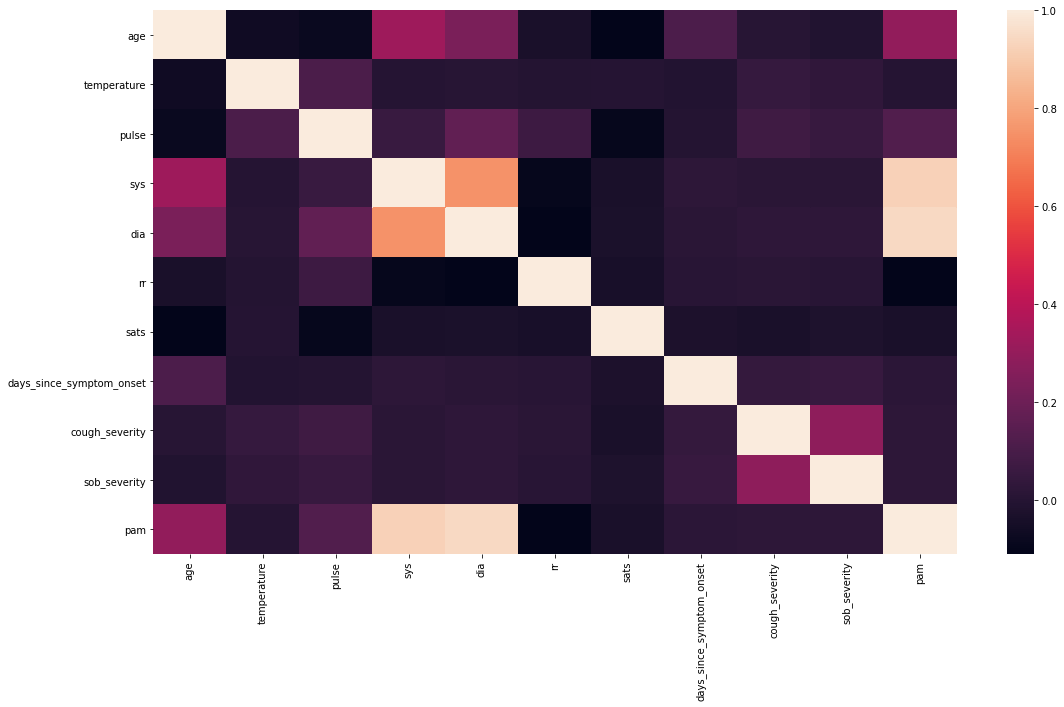

In [36]:
plt.figure(figsize=(18, 10))
sns.heatmap(pd.concat([X[significance_tests.index], pam], axis=1).corr(), xticklabels=list(significance_tests.index) + ["pam"], yticklabels= list(significance_tests.index) + ["pam"])
plt.show()

The new feature seems to be quite strong at predicting results since it's p-value is below our significance level so I added it to the `DataImputer` class. Also, as we can see above, <b>sys</b> and <b>dia</b> result to be highly correlated with each other as well as to a certain degree with other variables while <b>pam</b> does not seem to be correlated with anything but <b>age</b> to a lesser extent. Because of that, I will drop them during imputation.

### $\chi^{2}$ tests for independence between the covid test result and each categorial feature's values

$\alpha$: 0.005<br>

In [37]:
categorical_columns = [x for x in X.columns if X[x].dtype != "float64" or x == "cough_severity" or x == "sob_severity"]

values = []
for column in categorical_columns:
    
    a = all_data.groupby(by=["covid19_test_results", column], as_index=False).size().pivot(index=column, columns="covid19_test_results")
    
    #This is the formula for calculating the expected values of each cell:
    # - The a/a is just to make sure the matrix becomes 1
    # - The formula states that we have to calculate the probability of each cell, multiply those probabilities, and then multiply them by n. Doing algebra we arrive at the formula below
    #   (X/n) is the prob of X. (A/n) is the prob of A. To obtain the expected value of cell AX we do n*(X/n)*(A/n), which can just be reduced to (X*A)/n
    expected_values = (a/a) * (a.sum(axis=0)/a.values.sum()) * (a.sum(axis=1).values.reshape((a.shape[0], 1)))
        
    values.append(chisquare(f_obs=a.values.flatten(), f_exp=expected_values.values.flatten()))

chisquare_tests = pd.DataFrame(values, index=categorical_columns, columns=["chi-statistic", "p-value"])
chisquare_tests.style.apply(highlight_max) 

,chi-statistic,p-value
age,13.313841,0.064821
high_risk_exposure_occupation,29.764927,0.000002
high_risk_interactions,9.141420,0.027469
diabetes,15.903699,0.001187
chd,0.072217,0.994949
htn,0.048312,0.997216
cancer,0.016782,0.999425
asthma,4.264574,0.234276
autoimmune_dis,1.766320,0.622291
smoker,1.873253,0.599126


### Combine the most important numeric and categorical features according to the significance levels

In [38]:
numerical_features = significance_tests[significance_tests["p-value"] < 0.005].index
categorical_features = chisquare_tests[chisquare_tests["p-value"] < 0.005].index
selected_features = numerical_features.union(categorical_features).tolist()
print(len(selected_features))
selected_features

24


['cough',
 'cough_severity',
 'ctab',
 'days_since_symptom_onset',
 'dia',
 'diabetes',
 'diarrhea',
 'fatigue',
 'fever',
 'headache',
 'high_risk_exposure_occupation',
 'loss_of_smell',
 'loss_of_taste',
 'muscle_sore',
 'pulse',
 'rhonchi',
 'rr',
 'runny_nose',
 'sob',
 'sob_severity',
 'sore_throat',
 'sys',
 'temperature',
 'wheezes']

## Model development

In [39]:
models ={
    "GaussianNB" : GaussianNB(priors=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=100),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression(),
    "Ada Boost" : AdaBoostClassifier()
}

In [40]:
run_models(X, y, models, folds=30, ratio_negatives_to_positives=1)

GaussianNB
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (100 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

XGBoost Classifier
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVM
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

KNN
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Logistic Regression
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Ada Boost
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣



,F1,ROC_AUC
GaussianNB,0.582161,0.730893
Random Forest (100 estimators),0.664050,0.688981
XGBoost Classifier,0.654569,0.670944
SVM,0.658162,0.669147
KNN,0.639944,0.505254
Logistic Regression,0.685918,0.724983
Ada Boost,0.668339,0.666609


,F1,ROC_AUC
GaussianNB,0.5548-0.6095,0.714-0.7478
Random Forest (100 estimators),0.6556-0.6725,0.6713-0.7066
XGBoost Classifier,0.6366-0.6725,0.651-0.6909
SVM,0.6427-0.6736,0.6419-0.6964
KNN,0.6295-0.6504,0.4755-0.535
Logistic Regression,0.6667-0.7052,0.6996-0.7503
Ada Boost,0.6522-0.6845,0.6438-0.6894


In [41]:
run_models(X[selected_features], y, models, folds=30, ratio_negatives_to_positives=1)

GaussianNB
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Random Forest (100 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

XGBoost Classifier
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

SVM
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

KNN
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Logistic Regression
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Ada Boost
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣



,F1,ROC_AUC
GaussianNB,0.572204,0.704836
Random Forest (100 estimators),0.660807,0.665435
XGBoost Classifier,0.634824,0.637399
SVM,0.661878,0.683125
KNN,0.643125,0.525709
Logistic Regression,0.676692,0.734689
Ada Boost,0.665116,0.689064


,F1,ROC_AUC
GaussianNB,0.5421-0.6023,0.6798-0.7298
Random Forest (100 estimators),0.6546-0.667,0.6417-0.6892
XGBoost Classifier,0.6165-0.6531,0.6123-0.6625
SVM,0.6487-0.675,0.6533-0.7129
KNN,0.6321-0.6542,0.4996-0.5519
Logistic Regression,0.6603-0.6931,0.715-0.7543
Ada Boost,0.6535-0.6767,0.672-0.7061
